## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u (outputs)


We have to find out u(x) for all x in range [-10,10] 


When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$


Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 1 (x)
and #outputs = 1 (u)

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 3 hidden layer with 50 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(1,50)
        self.hidden_layer2 = nn.Linear(50,50)
        self.hidden_layer3 = nn.Linear(50,50)
        self.output_layer = nn.Linear(50,1)

    def forward(self, x):
        inputs = x # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out) ## For regression, no activation is used in output layer
        return output

## PINN

In [4]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [5]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x, net):
    u = net(x) # the dependent variable u is given by the network based on independent variables x,t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

In [6]:
## Data from Boundary Conditions
## BC just gives us datapoints for training

# BC tells us that for any x=-10 or 10, the value of u is given by analytical solution
x_bc = np.array([[-10],[10]])
# compute u based on BC
u_bc = np.sin(0.7*x_bc)+np.cos(1.5*x_bc)-0.1*x_bc

In [7]:
def exact_u(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [8]:
### (3) Training / Fitting
iterations = 5000*2
# previous_validation_loss = 99999999.0
T_error1=[]
T_BC1=[]
T_PDE1=[]
Step=[]
for epoch in range(600):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)
    

[0]-th step loss: 3.3495,  BC: 0.80322, residual: 2.54631
[100]-th step loss: 1.9968,  BC: 0.00013, residual: 1.99663
[200]-th step loss: 1.6034,  BC: 0.00120, residual: 1.60221
[300]-th step loss: 1.3864,  BC: 0.00006, residual: 1.38634
[400]-th step loss: 1.1902,  BC: 0.00243, residual: 1.18774
[500]-th step loss: 0.9309,  BC: 0.00078, residual: 0.93013


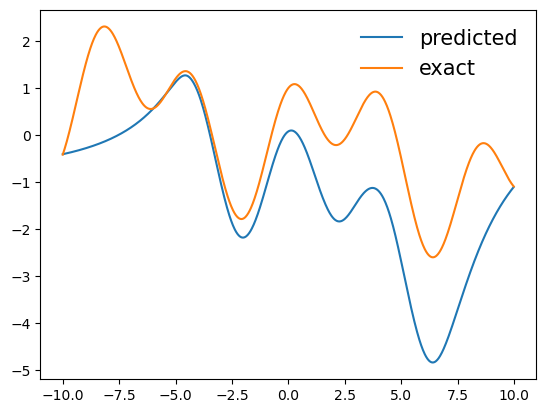

In [9]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

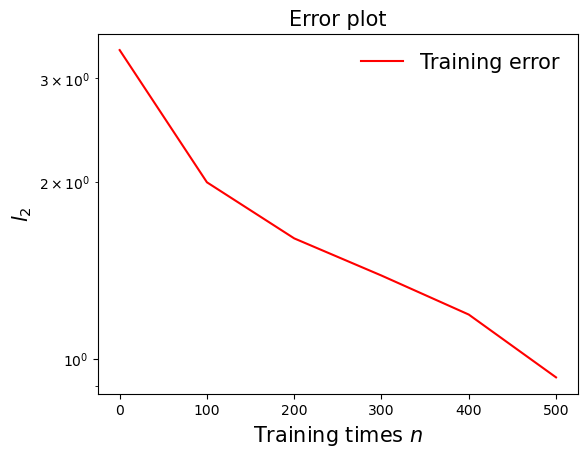

In [10]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [11]:
for epoch in range(600,900):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)

[600]-th step loss: 0.7175,  BC: 0.00007, residual: 0.71742
[700]-th step loss: 0.4710,  BC: 0.00044, residual: 0.47060
[800]-th step loss: 0.7239,  BC: 0.00090, residual: 0.72304


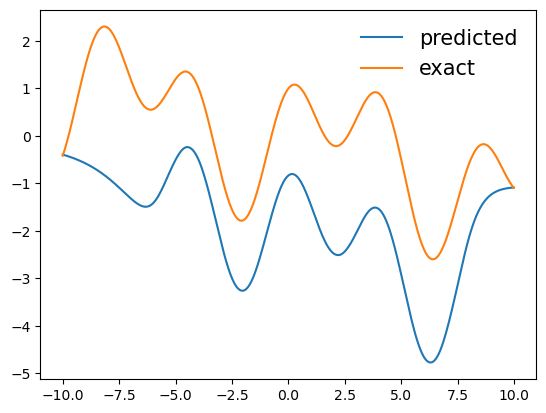

In [12]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

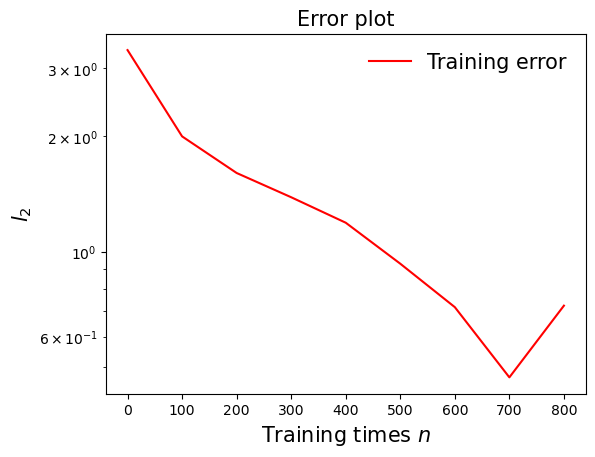

In [13]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [14]:
for epoch in range(900,5000):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)

[900]-th step loss: 0.3804,  BC: 0.00041, residual: 0.38000
[1000]-th step loss: 0.2404,  BC: 0.00047, residual: 0.23994
[1100]-th step loss: 0.1432,  BC: 0.00095, residual: 0.14224
[1200]-th step loss: 0.1560,  BC: 0.00015, residual: 0.15583
[1300]-th step loss: 0.0922,  BC: 0.00010, residual: 0.09212
[1400]-th step loss: 0.0717,  BC: 0.00010, residual: 0.07159
[1500]-th step loss: 0.0211,  BC: 0.00181, residual: 0.01933
[1600]-th step loss: 0.0096,  BC: 0.00232, residual: 0.00730
[1700]-th step loss: 0.0088,  BC: 0.00037, residual: 0.00841
[1800]-th step loss: 0.0074,  BC: 0.00002, residual: 0.00739
[1900]-th step loss: 0.0034,  BC: 0.00015, residual: 0.00321
[2000]-th step loss: 0.0049,  BC: 0.00032, residual: 0.00462
[2100]-th step loss: 0.0029,  BC: 0.00011, residual: 0.00284
[2200]-th step loss: 0.0036,  BC: 0.00078, residual: 0.00280
[2300]-th step loss: 0.0026,  BC: 0.00001, residual: 0.00262
[2400]-th step loss: 0.0012,  BC: 0.00004, residual: 0.00117
[2500]-th step loss: 0.00

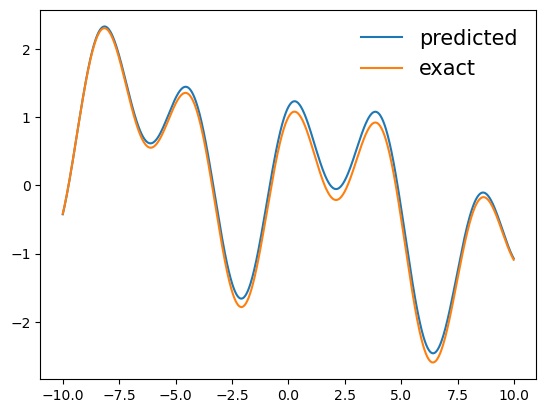

In [15]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

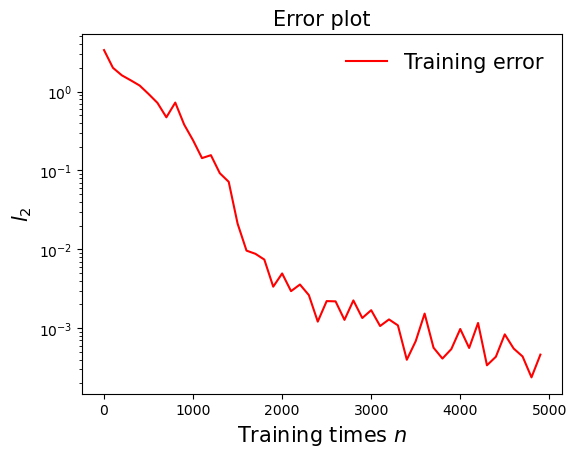

In [16]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [17]:
for epoch in range(5000,iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss, mse_b,mse_f))
            T_BC1.append(mse_b.detach().cpu().numpy())
            T_PDE1.append(mse_f.detach().cpu().numpy())
            T_error1.append(loss.detach().cpu().numpy())
            Step.append(epoch)

[5000]-th step loss: 0.0003,  BC: 0.00020, residual: 0.00012
[5100]-th step loss: 0.0012,  BC: 0.00034, residual: 0.00084
[5200]-th step loss: 0.0008,  BC: 0.00056, residual: 0.00026
[5300]-th step loss: 0.0005,  BC: 0.00032, residual: 0.00016
[5400]-th step loss: 0.0004,  BC: 0.00014, residual: 0.00031
[5500]-th step loss: 0.0002,  BC: 0.00004, residual: 0.00017
[5600]-th step loss: 0.0005,  BC: 0.00021, residual: 0.00026
[5700]-th step loss: 0.0009,  BC: 0.00046, residual: 0.00044
[5800]-th step loss: 0.0013,  BC: 0.00078, residual: 0.00057
[5900]-th step loss: 0.0001,  BC: 0.00004, residual: 0.00010
[6000]-th step loss: 0.0002,  BC: 0.00004, residual: 0.00015
[6100]-th step loss: 0.0003,  BC: 0.00002, residual: 0.00024
[6200]-th step loss: 0.0002,  BC: 0.00006, residual: 0.00009
[6300]-th step loss: 0.0001,  BC: 0.00002, residual: 0.00006
[6400]-th step loss: 0.0016,  BC: 0.00115, residual: 0.00045
[6500]-th step loss: 0.0004,  BC: 0.00001, residual: 0.00042
[6600]-th step loss: 0.0

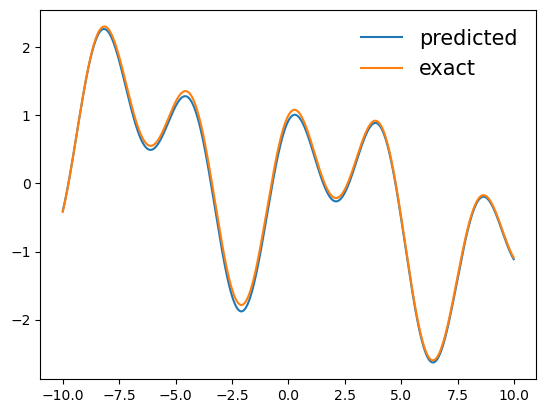

In [18]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

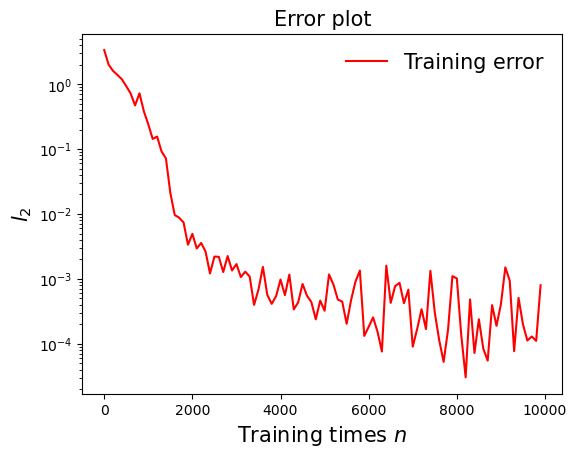

In [19]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='Training error')
# plt.ticklabel_format(axis='y', style='sci')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

## lbPINN

In [20]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [21]:
weight = torch.tensor([2.,0.2], requires_grad=True, device='cuda:0')
optimizer_weight = torch.optim.Adam([weight], lr=1e-3)

In [22]:
class MultipleOptimizer(object):
    def __init__(self,*op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [23]:
opt = MultipleOptimizer(optimizer_weight,optimizer)

In [24]:
### (3) Training / Fitting
T_error2=[]
T_BC2=[]
T_PDE2=[]
Step=[]
for epoch in range(600):
    opt.zero_grad()
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b/2/(weight.data[0]**2) + mse_f/2/(weight.data[1]**2) + torch.log(weight.data[0]*weight.data[1])
    
    loss.backward()
    opt.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

[0]-th step loss: 3.2952,  BC: 0.80830, residual: 2.48690
[100]-th step loss: 2.2967,  BC: 0.55053, residual: 1.74618
[200]-th step loss: 2.0772,  BC: 1.08802, residual: 0.98917
[300]-th step loss: 0.9071,  BC: 0.43584, residual: 0.47123
[400]-th step loss: 0.8653,  BC: 0.37244, residual: 0.49288
[500]-th step loss: 0.7290,  BC: 0.27916, residual: 0.44985


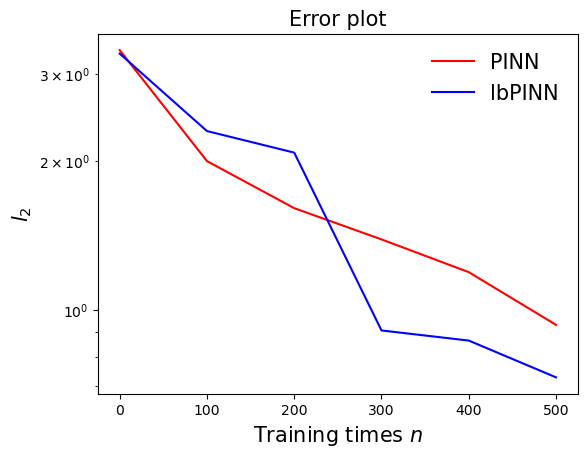

In [25]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1[:len(Step)],'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

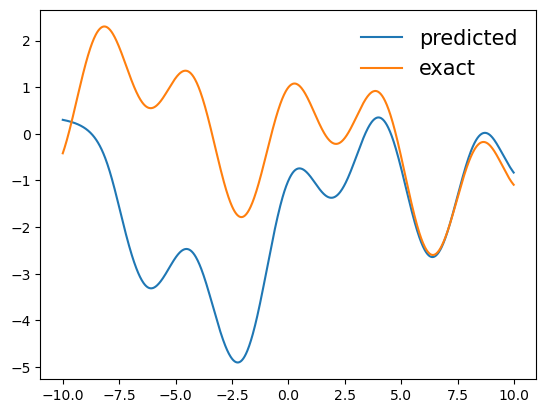

In [26]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [27]:
for epoch in range(600,900):
    opt.zero_grad()
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b/2/(weight.data[0]**2) + mse_f/2/(weight.data[1]**2) + torch.log(weight.data[0]*weight.data[1])
    
    loss.backward()
    opt.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

[600]-th step loss: 0.4293,  BC: 0.29128, residual: 0.13804
[700]-th step loss: 0.2933,  BC: 0.18526, residual: 0.10806
[800]-th step loss: 0.2093,  BC: 0.12983, residual: 0.07947


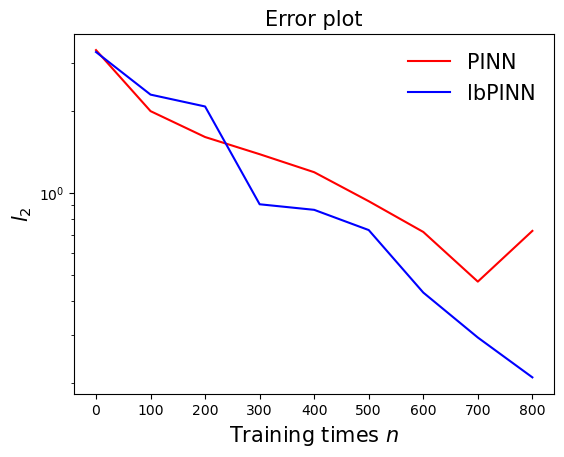

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1[:len(Step)],'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

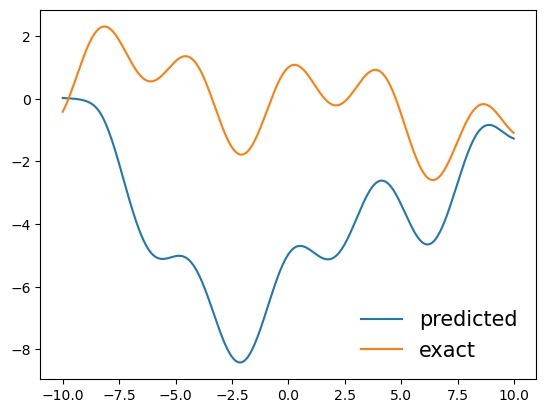

In [29]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [30]:
for epoch in range(900,5000):
    opt.zero_grad()
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b/2/(weight.data[0]**2) + mse_f/2/(weight.data[1]**2) + torch.log(weight.data[0]*weight.data[1])
    
    loss.backward()
    opt.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

[900]-th step loss: 0.1842,  BC: 0.11127, residual: 0.07292
[1000]-th step loss: 0.1918,  BC: 0.07712, residual: 0.11472
[1100]-th step loss: 0.2029,  BC: 0.09115, residual: 0.11179
[1200]-th step loss: 0.1863,  BC: 0.08873, residual: 0.09757
[1300]-th step loss: 0.1722,  BC: 0.08420, residual: 0.08802
[1400]-th step loss: 0.1279,  BC: 0.06182, residual: 0.06609
[1500]-th step loss: 0.0192,  BC: 0.00154, residual: 0.01765
[1600]-th step loss: 0.0150,  BC: 0.00754, residual: 0.00745
[1700]-th step loss: 0.0086,  BC: 0.00547, residual: 0.00318
[1800]-th step loss: 0.0044,  BC: 0.00291, residual: 0.00147
[1900]-th step loss: 0.0028,  BC: 0.00182, residual: 0.00096
[2000]-th step loss: 0.0019,  BC: 0.00120, residual: 0.00071
[2100]-th step loss: 0.0005,  BC: 0.00009, residual: 0.00041
[2200]-th step loss: 0.0002,  BC: 0.00006, residual: 0.00017
[2300]-th step loss: 0.0003,  BC: 0.00010, residual: 0.00023
[2400]-th step loss: 0.0001,  BC: 0.00005, residual: 0.00009
[2500]-th step loss: 0.00

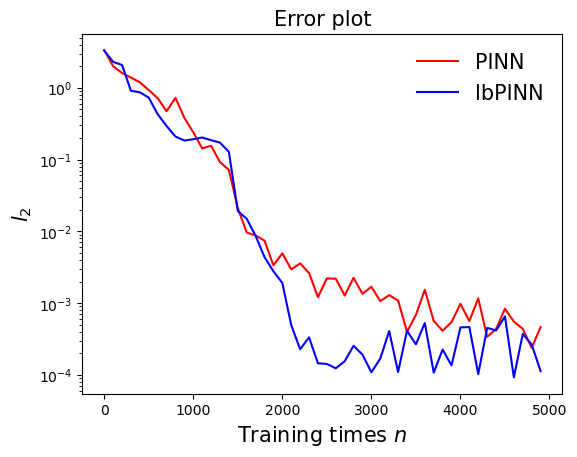

In [31]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1[:len(Step)],'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

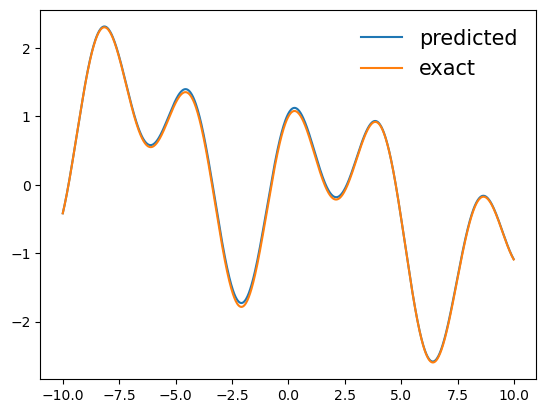

In [32]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

In [33]:
for epoch in range(5000,iterations):
    opt.zero_grad()
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc) # output of u(x,t)
    mse_b = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
    all_zeros = np.zeros((400,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_b/2/(weight.data[0]**2) + mse_f/2/(weight.data[1]**2) + torch.log(weight.data[0]*weight.data[1])
    
    loss.backward()
    opt.step()
    
    loss_sum = mse_b+mse_f

    if epoch % 100 == 0: 
        with torch.autograd.no_grad():
            print('[%d]-th step loss: %.4f,  BC: %.5f, residual: %.5f' % (epoch, loss_sum, mse_b,mse_f))
            T_BC2.append(mse_b.detach().cpu().numpy())
            T_PDE2.append(mse_f.detach().cpu().numpy())
            T_error2.append(loss_sum.detach().cpu().numpy())
            Step.append(epoch)

[5000]-th step loss: 0.0002,  BC: 0.00001, residual: 0.00018
[5100]-th step loss: 0.0006,  BC: 0.00007, residual: 0.00049
[5200]-th step loss: 0.0003,  BC: 0.00007, residual: 0.00024
[5300]-th step loss: 0.0003,  BC: 0.00005, residual: 0.00020
[5400]-th step loss: 0.0002,  BC: 0.00001, residual: 0.00017
[5500]-th step loss: 0.0003,  BC: 0.00007, residual: 0.00026
[5600]-th step loss: 0.0001,  BC: 0.00002, residual: 0.00013
[5700]-th step loss: 0.0002,  BC: 0.00005, residual: 0.00013
[5800]-th step loss: 0.0001,  BC: 0.00001, residual: 0.00007
[5900]-th step loss: 0.0004,  BC: 0.00001, residual: 0.00041
[6000]-th step loss: 0.0001,  BC: 0.00001, residual: 0.00014
[6100]-th step loss: 0.0005,  BC: 0.00011, residual: 0.00035
[6200]-th step loss: 0.0006,  BC: 0.00011, residual: 0.00049
[6300]-th step loss: 0.0001,  BC: 0.00001, residual: 0.00009
[6400]-th step loss: 0.0002,  BC: 0.00002, residual: 0.00018
[6500]-th step loss: 0.0014,  BC: 0.00051, residual: 0.00090
[6600]-th step loss: 0.0

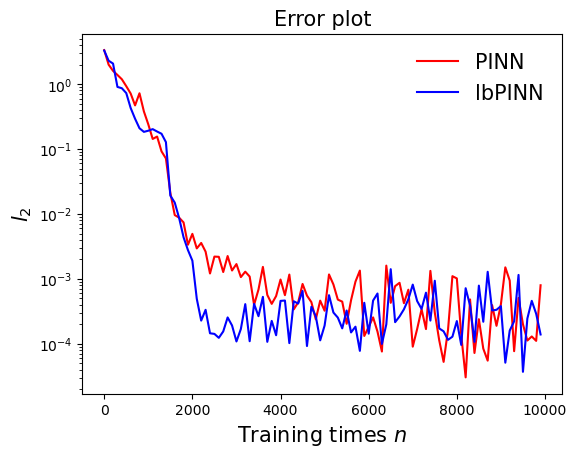

In [34]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error1,'r',label='PINN')
plt.semilogy(Step, T_error2,'b',label='lbPINN')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

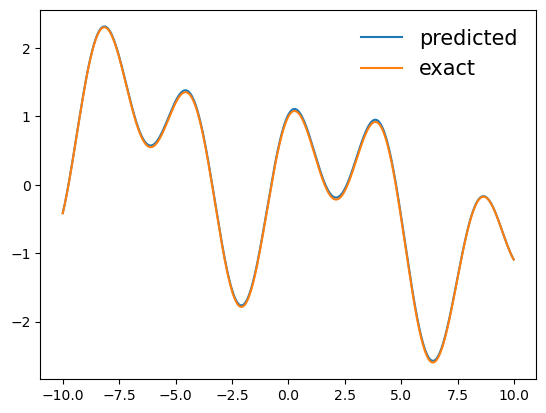

In [35]:
x=np.arange(-10,10,0.02).reshape((1000,1)) 
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_u = net(pt_x)
plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
plt.plot(x,exact_u(x), label='exact')
plt.legend(frameon=False,fontsize=15)

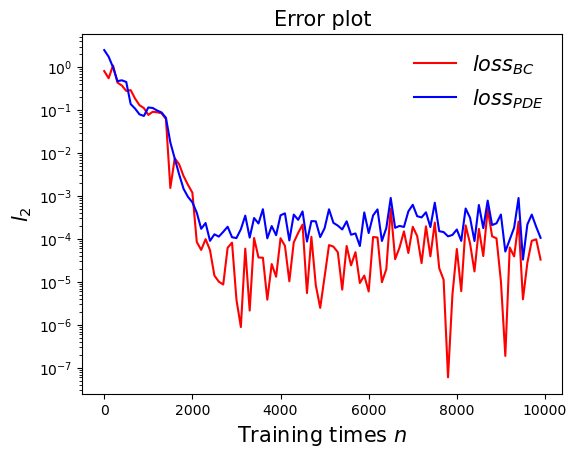

In [36]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_BC2,'r',label=r'$loss_{BC}$')
plt.semilogy(Step, T_PDE2,'b',label=r'$loss_{PDE}$')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)